 =================== Starting Tree-Fusion (PCA + Magpie + LGBM) for Debye Temp =================== 
Successfully loaded '6059_data.csv' and 'magpie_features.csv'
 =================== Step 1/5: Aligning data sources =================== 
 =================== Step 2/5: Loading 3D .npy data =================== 
Loaded 4900 3D samples and 4900 1D samples.
 =================== Step 3/5: Applying outlier removal (from FE script) =================== 
Original data shape: 4900
Removed 46 outliers
Data shape after outlier removal: 4854
 =================== Step 4/5: Engineering all 1D features =================== 
PCA complete. Explained variance: 0.8417
Created combined feature matrix with shape: (4854, 644)
 =================== Step 5/5: Creating KFold data splits =================== 
Train/Val/Test shapes: (3883, 644), (485, 644), (486, 644)

 =================== Training High-Performance LGBM (from FE script) ===================
Training until validation scores don't improve for 200 rounds
E

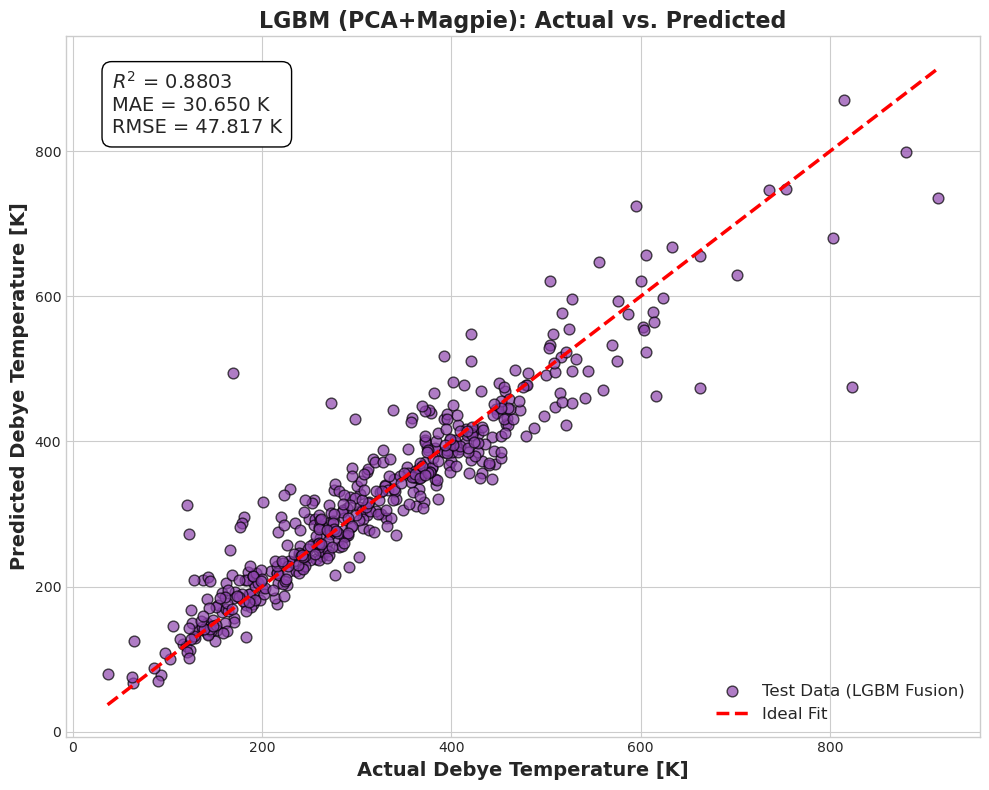

Script complete. Final model saved to 'To_Publish_Debye_Temperature_Best_On_CNN.pkl' and plot to 'To_Publish_Debye_Temperature_Best_On_CNN.png'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb
import joblib
import os
import random
import matplotlib.pyplot as plt
import warnings
from scipy import stats

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
warnings.filterwarnings('ignore')

print(" =================== Starting Tree-Fusion (PCA + Magpie + LGBM) for Debye Temp =================== ")
try:
    df_main = pd.read_csv('6059_rows.csv') 
    df_magpie = pd.read_csv('magpie_features.csv') 
    print("Successfully loaded '6059_data.csv' and 'magpie_features.csv'")
except FileNotFoundError as e:
    print(f"Error: Could not find data files. {e}")
    exit()

# --- 2. ALIGN, LOAD, AND CLEAN DATA ---
print(" =================== Step 1/5: Aligning data sources =================== ")
df_main = df_main.dropna(subset=['debye_temperature']) 
df_aligned = pd.merge(df_main, df_magpie, on='formula_sp', how='inner')
magpie_cols = [col for col in df_magpie.columns if col != 'formula_sp']

print(" =================== Step 2/5: Loading 3D .npy data =================== ")
X_cnn_list = []
y_list = []
input_dir = 'input_cnn'
found_formulas = []
for index, row in df_aligned.iterrows():
    file_path = os.path.join(input_dir, f"{row['formula_sp']}_latent.npy")
    if os.path.exists(file_path):
        X_cnn_list.append(np.load(file_path))
        y_list.append(row['debye_temperature'])
        found_formulas.append(row['formula_sp'])

df_aligned = df_aligned[df_aligned['formula_sp'].isin(found_formulas)].reset_index(drop=True)
X_magpie = df_aligned[magpie_cols].values
X_3d_raw = np.array(X_cnn_list)
y = np.array(y_list)
print(f"Loaded {X_3d_raw.shape[0]} 3D samples and {X_magpie.shape[0]} 1D samples.")

print(" =================== Step 3/5: Applying outlier removal (from FE script) =================== ")
def remove_outliers_advanced(X_3d_in, X_magpie_in, y_in):
    print(f"Original data shape: {X_3d_in.shape[0]}")
    Q1, Q3 = np.percentile(y_in, [10, 90]); IQR = Q3 - Q1
    mask1 = (y_in >= (Q1 - 2 * IQR)) & (y_in <= (Q3 + 2 * IQR))
    z_scores = np.abs(stats.zscore(y_in)); mask2 = z_scores < 3.5
    mask = mask1 & mask2
    print(f"Removed {len(y_in) - np.sum(mask)} outliers")
    return X_3d_in[mask], X_magpie_in[mask], y_in[mask]

X_3d_raw, X_magpie, y = remove_outliers_advanced(X_3d_raw, X_magpie, y)
print(f"Data shape after outlier removal: {X_3d_raw.shape[0]}")

# --- 3. FEATURE ENGINEERING & SCALING ---
print(" =================== Step 4/5: Engineering all 1D features =================== ")
X_3d_flat = X_3d_raw.reshape(X_3d_raw.shape[0], -1)
scaler_3d = StandardScaler()
X_3d_flat_scaled = scaler_3d.fit_transform(X_3d_flat)

n_components_pca = 512
pca = PCA(n_components=n_components_pca, random_state=seed_value)
X_pca = pca.fit_transform(X_3d_flat_scaled)
print(f"PCA complete. Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

scaler_magpie = StandardScaler()
X_magpie_scaled = scaler_magpie.fit_transform(X_magpie)

X_combined = np.concatenate([X_pca, X_magpie_scaled], axis=1)
print(f"Created combined feature matrix with shape: {X_combined.shape}")

# --- 4. SPLITTING ---
print(" =================== Step 5/5: Creating KFold data splits =================== ")
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
train_idx, temp_idx = next(kf.split(y))
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed_value)

X_train, X_val, X_test = X_combined[train_idx], X_combined[val_idx], X_combined[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx] # Train on raw y

print(f"Train/Val/Test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")

# --- 5. TRAIN LIGHTGBM MODEL ---
print("\n =================== Training High-Performance LGBM (from FE script) ===================")
model_lgbm = lgb.LGBMRegressor(
    random_state=seed_value, 
    n_estimators=5000, 
    learning_rate=0.005, 
    num_leaves=127, 
    max_depth=12, 
    min_child_samples=5, 
    subsample=0.8, 
    colsample_bytree=0.7, 
    reg_alpha=0.1, 
    reg_lambda=0.1, 
    min_split_gain=0.01, 
    n_jobs=-1, 
    device='cpu' # Kept on 'cpu' to avoid the build error
)

model_lgbm.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    eval_metric='l2',
    callbacks=[lgb.early_stopping(200, verbose=True)]
)

# --- 6. SAVE THE MODEL ---
model_filename = "To_Publish_Debye_Temperature_Best_On_CNN.pkl"
joblib.dump(model_lgbm, model_filename)
print(f"Best model saved to '{model_filename}'")

# --- 7. EVALUATE THE FINAL MODEL ---
print("\n =================== Evaluating Final LGBM Model ===================")
y_pred = model_lgbm.predict(X_test)
y_test_orig = y_test
y_pred_orig = y_pred

r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("\n" + "="*60); 
print(" =================== FINAL 'TREE-FUSION' MODEL RESULTS (Debye) ==================="); 
print("="*60)
print(f" R² Score:   {r2:.4f}"); 
print(f" MAE:        {mae:.4f} K"); 
print(f" RMSE:       {rmse:.4f} K")
print("="*60)

# --- 8. VISUALIZATION ---
print("Generating final plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

plt.scatter(y_test_orig, y_pred_orig, alpha=0.7, edgecolors='k', c='#e84393', s=60, label="Test Data (LGBM Fusion)")
ideal_line = [min(y_test_orig.min(), y_pred_orig.min()), max(y_test_orig.max(), y_pred_orig.max())]
plt.plot(ideal_line, ideal_line, 'r--', lw=2.5, label="Ideal Fit")

metrics_text = (
    fr'$R^2$ = {r2:.4f}' + '\n' +
    fr'MAE = {mae:.3f} K' + '\n' +
    fr'RMSE = {rmse:.3f} K'
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Actual Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.title(r'LGBM (PCA+Magpie): Actual vs. Predicted', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

plot_filename = "To_Publish_Debye_Temperature_Best_On_CNN.png"
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Script complete. Final model saved to '{model_filename}' and plot to '{plot_filename}'")

Generating final plot...


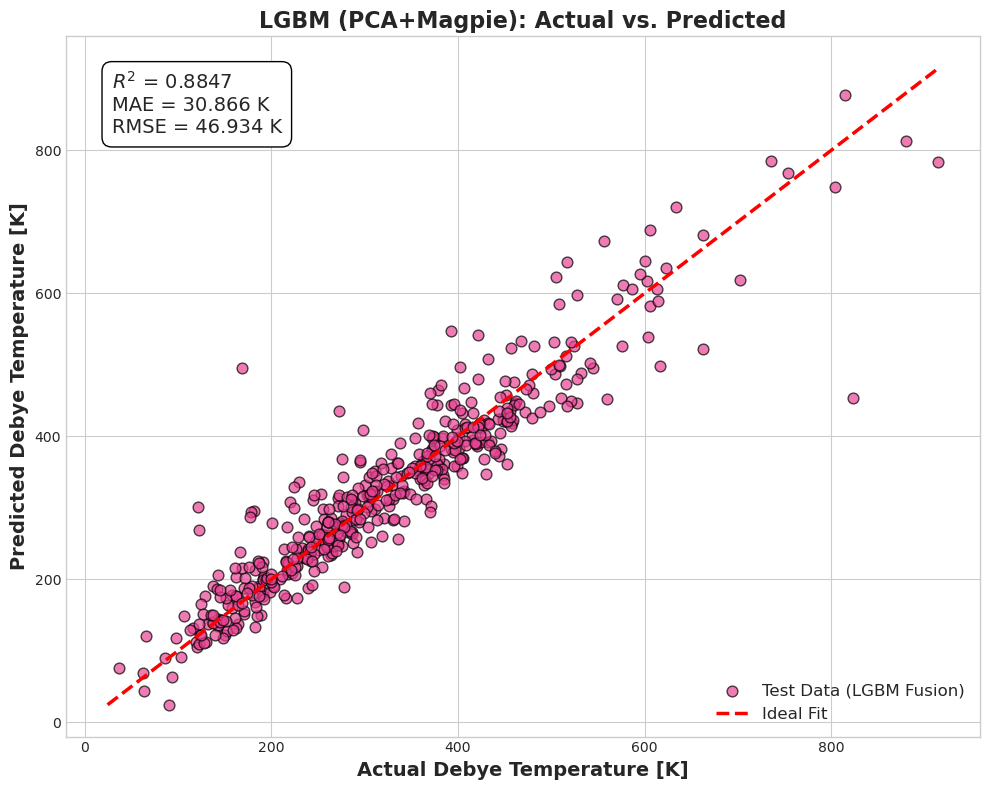

Script complete. Final model saved to 'To_Publish_Debye_Temperature_Best_On_CNN.pkl' and plot to 'To_Publish_Debye_Temperature_Best_On_CNN.png'


In [5]:
# --- 8. VISUALIZATION ---
print("Generating final plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

# CHANGED: Color for visual distinction
plt.scatter(y_test_orig, y_pred_orig, alpha=0.7, edgecolors='k', c='#e84393', s=60, label="Test Data (LGBM Fusion)")
ideal_line = [min(y_test_orig.min(), y_pred_orig.min()), max(y_test_orig.max(), y_pred_orig.max())]
plt.plot(ideal_line, ideal_line, 'r--', lw=2.5, label="Ideal Fit")

# CHANGED: Units to 'K'
metrics_text = (
    fr'$R^2$ = {r2:.4f}' + '\n' +
    fr'MAE = {mae:.3f} K' + '\n' +
    fr'RMSE = {rmse:.3f} K'
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# CHANGED: Axis labels for Debye Temperature
plt.xlabel("Actual Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.title(r'LGBM (PCA+Magpie): Actual vs. Predicted', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

# CHANGED: Filename for Debye Temperature
plot_filename = "To_Publish_Debye_Temperature_Best_On_CNN.png"
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Script complete. Final model saved to '{model_filename}' and plot to '{plot_filename}'")

 =================== Starting Tree-Fusion (Optuna Tuning) for Debye Temp =================== 
Successfully loaded '6059_data.csv' and 'magpie_features.csv'
 =================== Step 1/5: Aligning data sources =================== 
 =================== Step 2/5: Loading 3D .npy data =================== 
Loaded 4900 3D samples and 4900 1D samples.
 =================== Step 3/5: Applying outlier removal (from FE script) =================== 
Original data shape: 4900
Removed 46 outliers
Data shape after outlier removal: 4854
 =================== Step 4/5: Engineering all 1D features =================== 
PCA complete. Explained variance: 0.8417
Created combined feature matrix with shape: (4854, 644)
 =================== Step 5/5: Creating KFold data splits =================== 
Train/Val/Test shapes: (3883, 644), (485, 644), (486, 644)

 =================== Running Optuna Hyperparameter Search ===================

 =================== Optuna Search Complete ===================
Best Validation

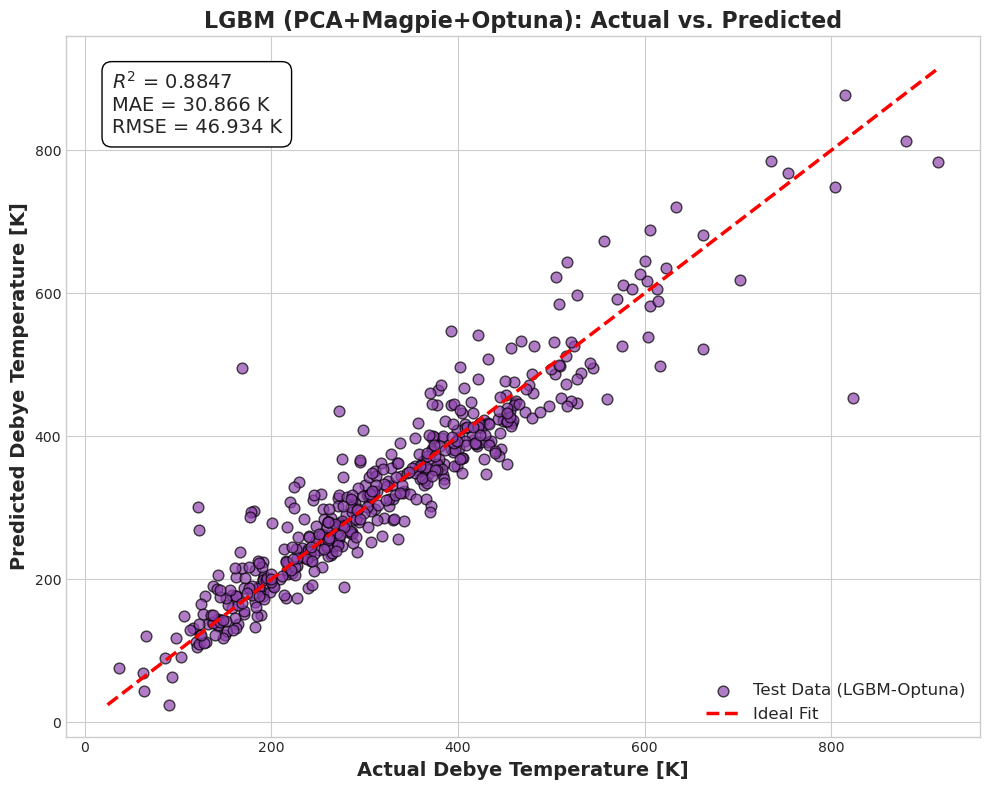

Script complete. Final model saved to 'To_Publish_Debye_Temperature_Best_On_CNN.pkl' and plot to 'To_Publish_Debye_Temperature_Best_On_CNN.png'


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb
import joblib
import os
import random
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import optuna  # <-- ADDED THIS IMPORT

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
warnings.filterwarnings('ignore')
# Suppress Optuna's trial logging
optuna.logging.set_verbosity(optuna.logging.WARNING) 

print(" =================== Starting Tree-Fusion (Optuna Tuning) for Debye Temp =================== ")
try:
    df_main = pd.read_csv('6059_data.csv') 
    df_magpie = pd.read_csv('magpie_features.csv') 
    print("Successfully loaded '6059_data.csv' and 'magpie_features.csv'")
except FileNotFoundError as e:
    print(f"Error: Could not find data files. {e}")
    exit()

# --- 2. ALIGN, LOAD, AND CLEAN DATA ---
print(" =================== Step 1/5: Aligning data sources =================== ")
df_main = df_main.dropna(subset=['debye_temperature']) 
df_aligned = pd.merge(df_main, df_magpie, on='formula_sp', how='inner')
magpie_cols = [col for col in df_magpie.columns if col != 'formula_sp']

print(" =================== Step 2/5: Loading 3D .npy data =================== ")
X_cnn_list = []
y_list = []
input_dir = 'input_cnn'
found_formulas = []
for index, row in df_aligned.iterrows():
    file_path = os.path.join(input_dir, f"{row['formula_sp']}_latent.npy")
    if os.path.exists(file_path):
        X_cnn_list.append(np.load(file_path))
        y_list.append(row['debye_temperature'])
        found_formulas.append(row['formula_sp'])

df_aligned = df_aligned[df_aligned['formula_sp'].isin(found_formulas)].reset_index(drop=True)
X_magpie = df_aligned[magpie_cols].values
X_3d_raw = np.array(X_cnn_list)
y = np.array(y_list)
print(f"Loaded {X_3d_raw.shape[0]} 3D samples and {X_magpie.shape[0]} 1D samples.")

print(" =================== Step 3/5: Applying outlier removal (from FE script) =================== ")
def remove_outliers_advanced(X_3d_in, X_magpie_in, y_in):
    print(f"Original data shape: {X_3d_in.shape[0]}")
    Q1, Q3 = np.percentile(y_in, [10, 90]); IQR = Q3 - Q1
    mask1 = (y_in >= (Q1 - 2 * IQR)) & (y_in <= (Q3 + 2 * IQR))
    z_scores = np.abs(stats.zscore(y_in)); mask2 = z_scores < 3.5
    mask = mask1 & mask2
    print(f"Removed {len(y_in) - np.sum(mask)} outliers")
    return X_3d_in[mask], X_magpie_in[mask], y_in[mask]

X_3d_raw, X_magpie, y = remove_outliers_advanced(X_3d_raw, X_magpie, y)
print(f"Data shape after outlier removal: {X_3d_raw.shape[0]}")

# --- 3. FEATURE ENGINEERING & SCALING ---
print(" =================== Step 4/5: Engineering all 1D features =================== ")
X_3d_flat = X_3d_raw.reshape(X_3d_raw.shape[0], -1)
scaler_3d = StandardScaler()
X_3d_flat_scaled = scaler_3d.fit_transform(X_3d_flat)

n_components_pca = 512
pca = PCA(n_components=n_components_pca, random_state=seed_value)
X_pca = pca.fit_transform(X_3d_flat_scaled)
print(f"PCA complete. Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

scaler_magpie = StandardScaler()
X_magpie_scaled = scaler_magpie.fit_transform(X_magpie)

X_combined = np.concatenate([X_pca, X_magpie_scaled], axis=1)
print(f"Created combined feature matrix with shape: {X_combined.shape}")

# --- 4. SPLITTING ---
print(" =================== Step 5/5: Creating KFold data splits =================== ")
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
train_idx, temp_idx = next(kf.split(y))
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed_value)

X_train, X_val, X_test = X_combined[train_idx], X_combined[val_idx], X_combined[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx] # Train on raw y

print(f"Train/Val/Test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")

# --- 5. NEW: OPTUNA HYPERPARAMETER TUNING ---
print("\n =================== Running Optuna Hyperparameter Search ===================")

def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'objective': 'regression_l2',
        'metric': 'l2',
        'n_estimators': 5000,
        'random_state': seed_value,
        'n_jobs': -1,
        'device': 'cpu',
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    # Train the model
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(200, verbose=False)]
    )
    
    # Evaluate on the validation set
    y_pred_val = model.predict(X_val)
    r2 = r2_score(y_val, y_pred_val)
    return r2

# Create a study object and optimize (maximize R^2)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # You can increase n_trials for a more thorough search

print("\n =================== Optuna Search Complete ===================")
print(f"Best Validation R²: {study.best_value:.4f}")
print("Best Hyperparameters found:")
print(study.best_params)


# --- 6. NEW: TRAIN FINAL MODEL WITH BEST PARAMS ---
print("\n =================== Training Final Model with Best Hyperparameters ===================")
# Get the best parameters and add back fixed ones
best_params = study.best_params
best_params.update({
    'n_estimators': 7000, # Use a high number with early stopping
    'random_state': seed_value,
    'n_jobs': -1,
    'device': 'cpu',
    'objective': 'regression_l2',
    'metric': 'l2',
    'verbose': -1,
})

final_model = lgb.LGBMRegressor(**best_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='l2',
    callbacks=[lgb.early_stopping(200, verbose=True)]
)

# Save the final, optimized model
model_filename = "To_Publish_Debye_Temperature_Best_On_CNN.pkl"
joblib.dump(final_model, model_filename)
print(f"Best model saved to '{model_filename}'")

# --- 7. EVALUATE THE FINAL MODEL ---
print("\n =================== Evaluating Final Optimized Model on TEST SET ===================")
y_pred = final_model.predict(X_test)
y_test_orig = y_test
y_pred_orig = y_pred

r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("\n" + "="*60); 
print(" =================== FINAL 'TREE-FUSION (OPTUNA)' MODEL RESULTS ==================="); 
print("="*60)
print(f" R² Score:   {r2:.4f}"); 
print(f" MAE:        {mae:.4f} K"); 
print(f" RMSE:       {rmse:.4f} K")
print("="*60)

# --- 8. VISUALIZATION ---
print("Generating final plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

plt.scatter(y_test_orig, y_pred_orig, alpha=0.7, edgecolors='k', c='#8e44ad', s=60, label="Test Data (LGBM-Optuna)")
ideal_line = [min(y_test_orig.min(), y_pred_orig.min()), max(y_test_orig.max(), y_pred_orig.max())]
plt.plot(ideal_line, ideal_line, 'r--', lw=2.5, label="Ideal Fit")

metrics_text = (
    fr'$R^2$ = {r2:.4f}' + '\n' +
    fr'MAE = {mae:.3f} K' + '\n' +
    fr'RMSE = {rmse:.3f} K'
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.xlabel("Actual Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Debye Temperature [K]", fontsize=14, fontweight='bold')
plt.title(r'LGBM (PCA+Magpie+Optuna): Actual vs. Predicted', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

plot_filename = "To_Publish_Debye_Temperature_Best_On_CNN.png"
plt.savefig(plot_filename, dpi=300)
plt.show()

print(f"Script complete. Final model saved to '{model_filename}' and plot to '{plot_filename}'")